### find pure domains (mostly path/benign vars)
* first show that knowing domain status helps
* then leave-one-out-cross-val to show this is realistic

In [25]:
import pandas, numpy

In [9]:
def calc_path_frac(rows):
    pfam = list(rows['pfam'].values)[0]
    pathogenic = len(rows[ (rows.clin_class=='PATHOGENIC') | (rows.clin_class=='LIKLEY_PATHOGENIC')])
    benign = len(rows[ (rows.clin_class=='LIKELY_BENIGN') | (rows.clin_class=='BENIGN')])
    frac = -1
    if pathogenic+benign:
        frac = pathogenic/(pathogenic+benign)
    return pandas.Series([frac, len(rows)], index=['path_frac', 'size'])

dat_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.dat.xls'
df_pre = pandas.read_csv(dat_file, sep='\t')
df = (df_pre['pfam'].str.split(',', expand=True)
     .stack()
     .reset_index(level=0)
     .set_index('level_0')
     .rename(columns={0:'pfam'})
     .join(df_pre.drop('pfam',1), how='left')
     )
dd = df.groupby('pfam').apply(calc_path_frac)

In [58]:
df_pre[df_pre.pos==166850715]

,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,...,mpc,exac_af,exac_ac,exac_an,exac_cov_frac,kaviar_af,c.,path_frac_t,size_t,path_na_t
2111,2,166850715,T,A,LIKLEY_PATHOGENIC,Ion_trans:492,0.0,missense_variant,2,8402,...,1.653,0.000009,1,115110,0.9919,0.000013,NM_001165963.1:c.4793A>T,1.0,7.0,0


In [3]:
ff = dd.reset_index()
# mostly path
#len(ff[(ff.size>4) & (ff.path_frac==1)])

In [4]:
# mostly benign
len(ff[(ff.size>4) & (ff.path_frac==0)])

111

In [10]:
# mk domain features
def match(row, domain_info):
    ls = []
    for pfam in row['pfam'].split(','):
        if domain_info[pfam][2] == 0:
            ls.append(domain_info[pfam])
    if len(ls) == 0:
        for pfam in row['pfam'].split(','):
            return domain_info[pfam]
        
    if len(ls) == 1:
        return ls[0]
    else:
        return ls[0]
    
ff.loc[:, 'path_na'] = ff.apply(lambda row: 1 if row['path_frac']==-1 else 0, axis=1)
domain_info = {pfam:[path_frac, size, path_na]
               for pfam, path_frac, size, path_na
               in ff.values}

df_pre.loc[:, 'path_frac_t'] = df_pre.apply(lambda row: match(row, domain_info)[0], axis=1)
df_pre.loc[:, 'size_t'] = df_pre.apply(lambda row: match(row, domain_info)[1], axis=1)
df_pre.loc[:, 'path_na_t'] = df_pre.apply(lambda row: match(row, domain_info)[2], axis=1)

In [11]:
## predict
import pandas, pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics, tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
from IPython.display import HTML
%matplotlib inline

In [19]:
df_x_pre = df_pre[ (df_pre.clin_class != 'VUS') & (df_pre.mpc>0) & (df_pre.pfam != 'none')]
df_s = df_x_pre.groupby('pfam').size().reset_index()
multi_pfam = set( df_s[df_s[0]>1]['pfam'].values )
df_x_pre.loc[:, 'multi_pfam'] = df_x_pre.apply(lambda row: row['pfam'] in multi_pfam, axis=1)
df_x = df_x_pre[df_x_pre.multi_pfam]
df_x.loc[:, 'y'] = df_x.apply(lambda row: 1 if row['clin_class'] in ('PATHOGENIC', 'LIKLEY_PATHOGENIC')
                            else 0, axis=1)
df_x.head()

/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,...,exac_ac,exac_an,exac_cov_frac,kaviar_af,c.,path_frac_t,size_t,path_na_t,multi_pfam,y
18,1,40557754,A,C,PATHOGENIC,Palm_thioest:10,0.0,missense_variant,1,8544,...,1,121364,0.9998,0.000006,NM_000310.3:c.325T>G,0.5,3.0,0,True,1
19,1,40557769,T,C,LIKELY_BENIGN,Palm_thioest:10,0.0,missense_variant,2,8543,...,3,121374,1.0000,0.000019,NM_000310.3:c.310A>G,0.5,3.0,0,True,0
34,1,43393355,C,T,PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.0,missense_variant,1,8419,...,0,0,0.9988,0.000000,NM_006516.2:c.1199G>A,1.0,9.0,0,True,1
35,1,43393356,G,A,PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.0,missense_variant,2,8418,...,0,0,0.9986,0.000006,NM_006516.2:c.1198C>T,1.0,9.0,0,True,1
36,1,43393397,A,C,LIKLEY_PATHOGENIC,"MFS_1:44,Sugar_tr:29",0.0,missense_variant,1,8419,...,0,0,0.9986,0.000006,NM_006516.2:c.1157T>G,1.0,9.0,0,True,1


In [89]:
tree_clf = tree.DecisionTreeClassifier(max_depth=2)

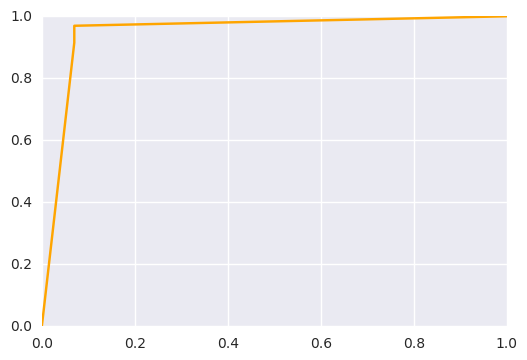

In [22]:
# decision tree
# only use domains w/ more than one variant
all_preds = []
all_truth = []
cols = ['mpc', 'size_t', 'path_na_t', 'path_frac_t']
genes = set(df_x['gene'].values)
for gene in genes:
    df_train = df_x[df_x.gene!=gene]
    df_test = df_x[df_x.gene==gene]
    X, y = df_train[cols], df_train['y']
    tree_clf.fit(X, y)
    dot_data = StringIO()
    tree.export_graphviz(tree_clf, feature_names=cols, out_file=dot_data)
    graph = pydotplus.graph_from_dot_data( dot_data.getvalue() )
    graph.write_pdf('mtr_tree.%s.pdf' % (gene,))
    X_test, y_test = df_test[cols], df_test['y']
    preds = tree_clf.predict_proba(X_test)
    preds_simple = tree_clf.predict(X_test)
    tot, good = 0,0
    for pred, pred_s, truth in zip(preds, preds_simple, y_test):
        all_preds.append(pred[1])
        all_truth.append(truth)
        tot += 1
        if pred_s==truth:
            good += 1
    #print(gene, tot, good, good/tot)
fpr_tree, tpr_tree, _ = metrics.roc_curve(all_truth, all_preds, pos_label=1)
plt.plot(fpr_tree, tpr_tree, label='tree', color='orange')

In [23]:
HTML('<iframe src=./mtr_tree.CDKL5.pdf width=1000 height=500></iframe>')

In [8]:
# either predict path/benign
# or hold out one at a time and compute fraction?
# how do 
pfam_set = set(df_x['pfam'])
print( len(pfam_set) )

221


In [17]:
s = df_x.groupby('pfam').size().reset_index()
len( s[s[0]==1] )

130

In [24]:
len(df_x)

380

In [49]:
from collections import Counter

In [59]:
df_x[df_x.pos==166850715]

,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,...,exac_an,exac_cov_frac,kaviar_af,c.,path_frac_t,size_t,path_na_t,multi_pfam,y,is_test
2111,2,166850715,T,A,LIKLEY_PATHOGENIC,Ion_trans:492,0.0,missense_variant,2,8402,...,115110,0.9919,0.000013,NM_001165963.1:c.4793A>T,1.0,7.0,0,True,1,False


In [67]:
cc = ['chrom','pos','ref','alt']
fn = lambda obj: obj.loc[numpy.random.choice(obj.index, 1), cc]
y_shit = df_x.groupby('pfam').apply(fn)
y_shit[y_shit.pos==166850715]

,,chrom,pos,ref,alt
pfam,,,,,
Ion_trans:492,2111,2,166850715,T,A


/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

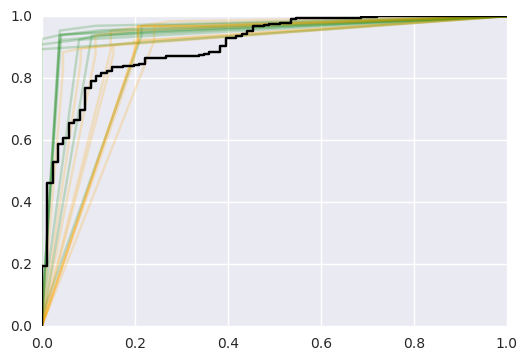

In [107]:
def loop(use_cols):
    cc = ['chrom','pos','ref','alt']
    y_set = {':'.join([str(y) for y in ls]) for ls in 
             df_x.groupby('pfam').apply(fn).values}
    y_eval = df_x.apply(lambda row: ':'.join([str(row[x]) for x in cc]) in y_set, axis=1)
    df_x['is_test'] = y_eval
    
    df_train = df_x[~df_x.is_test]
    df_tmp = (df_train['pfam'].str.split(',', expand=True)
             .stack()
             .reset_index(level=0)
             .set_index('level_0')
             .rename(columns={0:'pfam'})
             .join(df_pre.drop('pfam',1), how='left')
             )
    dd_tmp = df_tmp.groupby('pfam').apply(calc_path_frac)
    ff_tmp = dd_tmp.reset_index()

    ff_tmp.loc[:, 'path_na'] = ff_tmp.apply(lambda row: 1 if row['path_frac']==-1 else 0, axis=1)
    domain_info = {pfam:[path_frac, size, path_na]
                   for pfam, path_frac, size, path_na
                   in ff_tmp.values}

    df_train.loc[:, 'path_frac_c'] = df_train.apply(lambda row: match(row, domain_info)[0], axis=1)
    df_train.loc[:, 'size_c'] = df_train.apply(lambda row: match(row, domain_info)[1], axis=1)
    df_train.loc[:, 'path_na_c'] = df_train.apply(lambda row: match(row, domain_info)[2], axis=1)

    df_test = df_x[df_x.is_test]
    df_test.loc[:, 'path_frac_c'] = df_test.apply(lambda row: match(row, domain_info)[0], axis=1)
    df_test.loc[:, 'size_c'] = df_test.apply(lambda row: match(row, domain_info)[1], axis=1)
    df_test.loc[:, 'path_na_c'] = df_test.apply(lambda row: match(row, domain_info)[2], axis=1)

    cols = use_cols#['mpc', 'size_c', 'path_na_c', 'path_frac_c']
    X, y = df_train[cols], df_train['y']
    tree_clf.fit(X, y)
    dot_data = StringIO()
    tree.export_graphviz(tree_clf, feature_names=cols, out_file=dot_data)
    graph = pydotplus.graph_from_dot_data( dot_data.getvalue() )
    graph.write_pdf('mtr_tree.x.pdf')
    X_test, y_test = df_test[cols], df_test['y']
    preds = tree_clf.predict_proba(X_test)
    fpr_tree, tpr_tree, _ = metrics.roc_curve(list(y_test), [p[1] for p in preds], pos_label=1)
    return fpr_tree, tpr_tree

for x in range(10):
    use_cols = ['mpc', 'size_c', 'path_na_c', 'path_frac_c']
    fpr_tree, tpr_tree = loop(use_cols)
    plt.plot(fpr_tree, tpr_tree, label='tree', color='green', alpha=0.2)
    
    use_cols = ['size_c', 'path_na_c', 'path_frac_c']
    fpr_tree, tpr_tree = loop(use_cols)
    plt.plot(fpr_tree, tpr_tree, label='tree-no-mpc', color='orange', alpha=0.2)    
    
scores = df_x['mpc'].values
truth = df_x['y'].values
fpr_mpc, tpr_mpc, _ = metrics.roc_curve(truth, scores, pos_label=1)
plt.plot(fpr_mpc, tpr_mpc, label='mpc', color='black')
plt.savefig('roc.png')

In [90]:
# problem: on y can be in multiple domains
# 9:131344110:C:C <- not a change
# 2:166850715:A:A <- not a change
#  NM_001165963.1:c.4793A>T and NM_001130438.1:c.1511C>T have wrong pattern
pfams = set(df_x['pfam'])
print('total pfams', len(pfams))
cc = ['chrom','pos','ref','alt']
y_set = {':'.join([str(y) for y in ls]) for ls in 
         df_x.groupby('pfam').apply(fn).values}
print( 'this many y', len(y_set) )
#print(y_set)
keys = [':'.join([str(xx) for xx in x]) for x in df_x[cc].values]
for y in y_set:
    if not y in keys:
        print(y)
y_eval = df_x.apply(lambda row: ':'.join([str(row[x]) for x in cc]) in y_set, axis=1)
df_x['is_test'] = y_eval
print( Counter(df_x['is_test']) )
print( Counter(y_eval) )

total pfams 91
this many y 91
Counter({False: 289, True: 91})
Counter({False: 289, True: 91})


/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


this many domains 105


/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


this many vars 380
this many train vars 289
this many test vars 91


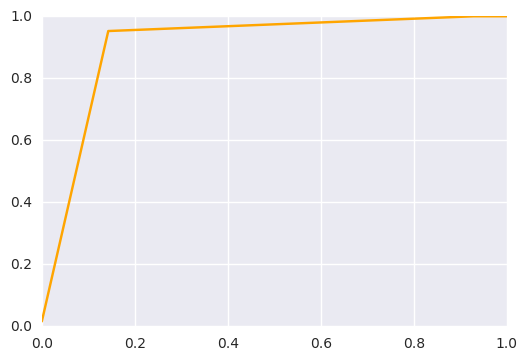

In [91]:
df_train = df_x[~df_x.is_test]
# calc fracs
df_tmp = (df_train['pfam'].str.split(',', expand=True)
         .stack()
         .reset_index(level=0)
         .set_index('level_0')
         .rename(columns={0:'pfam'})
         .join(df_pre.drop('pfam',1), how='left')
         )
dd_tmp = df_tmp.groupby('pfam').apply(calc_path_frac)
ff_tmp = dd_tmp.reset_index()
print('this many domains', len(ff_tmp))

ff_tmp.loc[:, 'path_na'] = ff_tmp.apply(lambda row: 1 if row['path_frac']==-1 else 0, axis=1)
domain_info = {pfam:[path_frac, size, path_na]
               for pfam, path_frac, size, path_na
               in ff_tmp.values}

df_train.loc[:, 'path_frac_c'] = df_train.apply(lambda row: match(row, domain_info)[0], axis=1)
df_train.loc[:, 'size_c'] = df_train.apply(lambda row: match(row, domain_info)[1], axis=1)
df_train.loc[:, 'path_na_c'] = df_train.apply(lambda row: match(row, domain_info)[2], axis=1)

df_test = df_x[df_x.is_test]
df_test.loc[:, 'path_frac_c'] = df_test.apply(lambda row: match(row, domain_info)[0], axis=1)
df_test.loc[:, 'size_c'] = df_test.apply(lambda row: match(row, domain_info)[1], axis=1)
df_test.loc[:, 'path_na_c'] = df_test.apply(lambda row: match(row, domain_info)[2], axis=1)

print('this many vars', len(df_x))
print('this many train vars', len(df_train))
print('this many test vars', len(df_test))

cols = ['mpc', 'size_c', 'path_na_c', 'path_frac_c']
X, y = df_train[cols], df_train['y']
tree_clf.fit(X, y)
dot_data = StringIO()
tree.export_graphviz(tree_clf, feature_names=cols, out_file=dot_data)
graph = pydotplus.graph_from_dot_data( dot_data.getvalue() )
graph.write_pdf('mtr_tree.x.pdf')
X_test, y_test = df_test[cols], df_test['y']
preds = tree_clf.predict_proba(X_test)
#print(preds)
fpr_tree, tpr_tree, _ = metrics.roc_curve(list(y_test), [p[1] for p in preds], pos_label=1)
plt.plot(fpr_tree, tpr_tree, label='tree', color='orange')

In [92]:
HTML('<iframe src=./mtr_tree.x.pdf width=1000 height=500></iframe>')

In [106]:
df_x.groupby(['gene','y']).size().reset_index().rename(columns={0:'size'}).to_csv('eval_dat', index=False, sep='\t')